### Cat or non-cat detector using a manual implementation of Logistic Regression 

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import sys
sys.path.append('../../')
from ML_toolbox import *

In [4]:
# Load the training and test data from h5 files
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

# Explore the contents
train_keys = train_dataset.keys()
test_keys = test_dataset.keys()
print('#Training dataset keys:\n', train_keys)
for key in train_keys: 
    print(train_dataset[key])

print('#Test dataset keys:\n', test_keys)
for key in test_keys: 
    print(test_dataset[key])


#Training dataset keys:
 <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
<HDF5 dataset "list_classes": shape (2,), type "|S7">
<HDF5 dataset "train_set_x": shape (209, 64, 64, 3), type "|u1">
<HDF5 dataset "train_set_y": shape (209,), type "<i8">
#Test dataset keys:
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>
<HDF5 dataset "list_classes": shape (2,), type "|S7">
<HDF5 dataset "test_set_x": shape (50, 64, 64, 3), type "|u1">
<HDF5 dataset "test_set_y": shape (50,), type "<i8">


y = 1. It is a cat


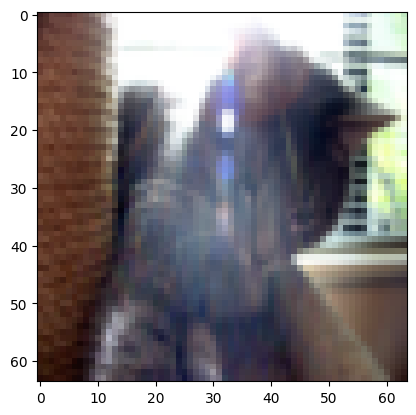

In [5]:
# Create necessary numpy arrays from data
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # Training dataset RGB images
Y_train = np.array(train_dataset["train_set_y"][:]) # Training dataset labels

test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # Test dataset RGB images
test_set_y = np.array(test_dataset["test_set_y"][:]) # Test dataset labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
Y_train = Y_train.reshape((1, Y_train.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

# Save some sizes in variables for convenience
m_train = train_set_x_orig.shape[0] # Number of training examples
m_test = test_set_x_orig.shape[0] # Number of test examples
num_px = train_set_x_orig.shape[1] # Size of each image (square images here of num_px * num_px size)

# Example of a picture
index = 42
plt.imshow(train_set_x_orig[index])
y = int(Y_train[:, index]) # or np.squeeze instead of int to remove brackets
print(f'y = {y}. It is a {classes[y].decode("utf-8")}')


In [6]:
# Flatten images into single vectors (Each image of num_px*num_px*3 becomes a single vector)
# Training/ test data sets becomes an array of these single vectors
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print (f'train_set_x_orig shape: {train_set_x_orig.shape}, train_set_x_flatten shape: {train_set_x_flatten.shape}')
print ("train_set_y shape: " + str(Y_train.shape))
print (f'test_set_x_orig shape: {test_set_x_orig.shape}, test_set_x_flatten shape: {test_set_x_flatten.shape}')
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_orig shape: (209, 64, 64, 3), train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3), test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [7]:
# Standardize pixel data
X_train = train_set_x_flatten / 255.
X_test = test_set_x_flatten / 255.

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    Z = np.sum(w * X, axis=0) + b
    A = sigmoid(Z)
    cost = -1 * np.mean(Y * np.log(A) + (1 - Y) * np.log(1-A))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.mean(X * (A - Y), axis=1, keepdims=True)
    db = np.mean(A - Y)
    
    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update w, b
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.sum(w * X, axis=0, keepdims=True) + b)
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    return Y_prediction


def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    feature_count = X_train.shape[0] # Number of pixels over all channels
    # Initialize weights and biases with zeros
    w = np.zeros((feature_count, 1))
    b = 0.
    
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d



In [9]:
## TODO: check why this can't be done using the ML_toolbox functions....
logistic_regression_model = model(X_train, Y_train, X_test, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)



Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y (label) = 0 (non-cat)
prediction: cat


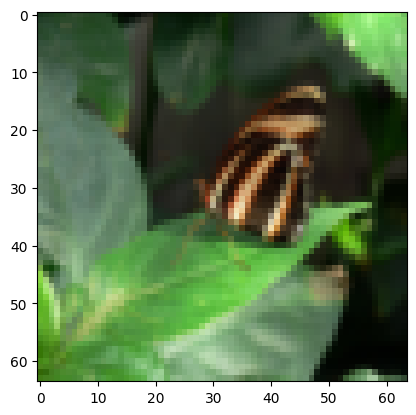

In [10]:
# Checkout wrong predictions
labels = test_set_y[0]
preds = logistic_regression_model['Y_prediction_test'][0]

wrong_prediction_indicies = np.where(preds != labels)
# Show one wrong example
index = np.squeeze(wrong_prediction_indicies)[0]
plt.imshow(X_test[:, index].reshape((num_px, num_px, 3)))
#print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")
print (f'y (label) = {labels[index]} ({classes[int(labels[index])].decode("utf-8")})\nprediction: {classes[int(preds[index])].decode("utf-8")}')

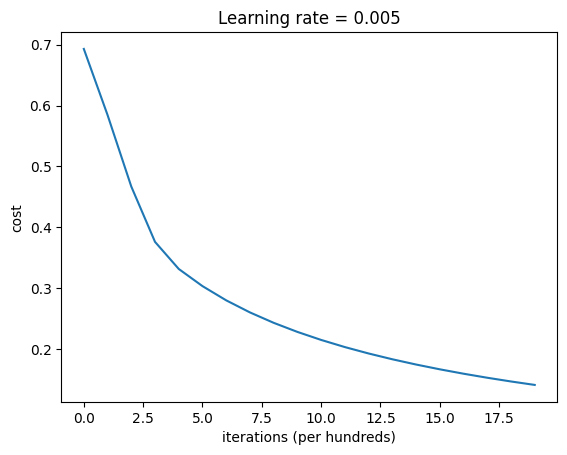

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title(f'Learning rate = {str(logistic_regression_model["learning_rate"])}')
plt.show()

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



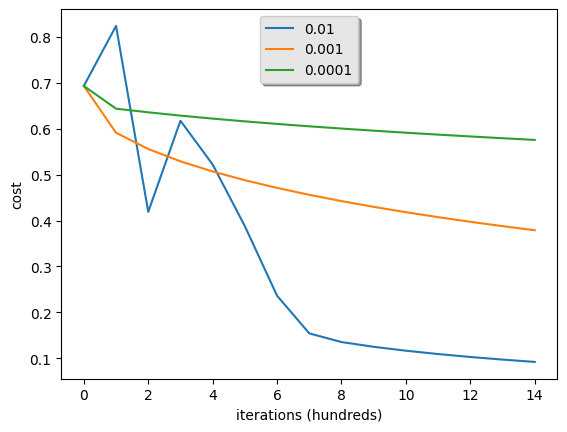

In [12]:
# Test and analyze different learning rates
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(X_train, Y_train, X_test, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Prediction = 1 (cat)


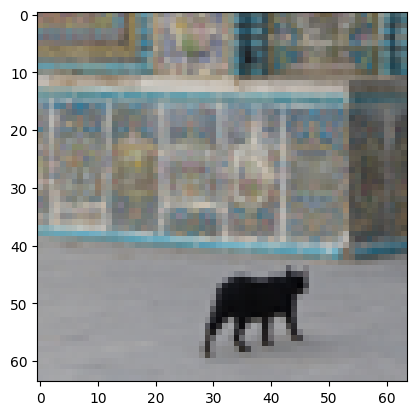

In [13]:
# Test the model with new unseen data
fname = "images/cat_in_iran.jpg"

# Preprocess the image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print(f'Prediction = {str(np.squeeze(my_predicted_image))} ({classes[int(np.squeeze(my_predicted_image)),].decode("utf-8")})')